# Приложение для знакомств

## Общее описание:
Команда приложения разработала новый алгоритм для дользователей: поиск наиболее подходящих анкет сайта. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

### Задача:
Оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать одну или несколько метрик, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.


### План

1. **Сначала сделаем небольшой препроцессинг:**
    - Посмотрим на данные
    
2. **Далее сформулируем гипотезы, исходя из общей задачи:**
    - Сформулируем предположения, которые будем тестировать

3. **Тестируем гипотезы:**
     - Выбираем гипотезу
     - Выбираем подходящий тест
     - Тестируем
     
4. **Подводим итоги:**

### 1. Выгрузка и изучение имеющихся данных

In [85]:
# Импорт требуемых библиотек

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as ss
from scipy.stats import chi2_contingency, chi2 
import pingouin as pg

In [86]:
# Обзор исследуемого датафрейма 

df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-h-gajzetdinova/Statistics/dating_data.csv')
df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [87]:
# Проверка на наличие пропусков

df.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [88]:
# Уникальное количество пользователей в каждой группе

df.groupby('group', as_index=False).user_id_1.nunique().rename(columns={'user_id_1': 'count_users'})

,group,count_users
0,0,501
1,1,499


In [89]:
# Результирующее количество наблюдений в каждой группе

df.groupby('group', as_index=False).size()

,group,size
0,0,4792
1,1,9722


Данные не содержат пропусков, исследуемые группы практически одного размера:
- Пользователи в группе 0 пользовались приложением со старым алгоритмом (501 пользователь). 
- Пользователи в группе 1 пользовались приложением с новым алгоритмом (499 пользователей).

Если мэтч между пользователями случился, is_match = 1 или is_match = 0, если мэтча не произошло.

Результирующее количество наблюдений демонстрирует практически х2 превышение наблюдений в тестовой группе по сравнению с контрольной (9722 и 4792 наблюдения). 
На первый взгляд кажется, что новый алгоритм позволяет увеличивать активность пользователей в приложении. Но для оценки статистической значимости данных сведений недостаточно. Сформулируем основные гипотезы, определим уровень значимости для компании, проведем тестирование и подведем итоги.  

### 2. Формулировка гипотез, исходя из общей задачи:

1. Проверим взаимосвязь двух номинативных переменных: 
    правда ли, что новый алгоритм положительно повлиял на мэтчи между пользователями. 
2. Для дополнительной проверки проанализируем количество анкет на каждого пользователя в зависимости от группы: позволили ли изменения увеличить количество анкет на пользователя.

Перед проведением А/В тестирования определим основную и альтернативную гипотезы и критический уровень статистической значимости:
- Нулевая гипотеза: новый алгоритм не изменил качество сервиса
- Альтернативная гипотеза: новый алгоритм качество сервиса улучшил

Уровень значимости p-value = 0.05 

Если в результате экспериментов полученное значение превысит наш уровень значимости, то принимаем нулевую гипотезу.

In [90]:
# Убедимся, что участники не попадают одновременно в экспериментальную и контрольную группу

df.groupby(['user_id_1', 'user_id_2'], as_index=False).agg({'group':'nunique'}).query('group > 1')

,user_id_1,user_id_2,group


### 3. Выбор и тестирование гипотезы 
#### 3.1 Новый алгоритм увеличил количество мэтчей между пользователями? 
Для проверки нашей гипотезы воспользуемся Критерием Хи-квадрат. 
Данный криерий используется для определения того, существует ли существенная связь между двумя категориальными переменными.

Для начала визуально оценим влияние нового алгоритма на увеличение мэтчей на пользователя по группам

In [91]:
# Подсчет пользователей, у которых был мэтч, в зависимости от группы

match = df.query('is_match == 1') \
        .groupby(['group', 'user_id_1'], as_index=False) \
        .user_id_2.count() \
        .rename(columns={'user_id_2': 'count_match'})
match.head()

,group,user_id_1,count_match
0,0,4,2
1,0,10,3
2,0,12,1
3,0,15,3
4,0,17,1


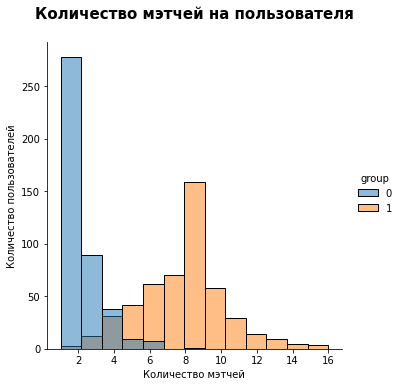

In [92]:
# Графическое отображение числа мэтчей на пользователя

sns.displot(match, x = 'count_match', hue='group')
plt.ylabel("Количество пользователей")
plt.xlabel("Количество мэтчей")
plt.title("Количество мэтчей на пользователя\n", fontsize=15, fontweight = 'bold')
plt.show()

Полученная визуализация демонстрирует положительное влияние эксперимента- пользователи стали больше мэтчиться. Приступим к проверке гипотезы с помощью стат. методов

In [93]:
# Подготовим таблицу сопряженности

cross_table = pd.crosstab(df.group, df.is_match)
cross_table

is_match,0,1
group,,
0,3858,934
1,5813,3909


Полученные значения мэтчей в экспериментальной значительно выше, чем в контрольной. Неплохо, но проверим насколько эти различия статистически значимые, чтобы принять решение по внедрению нового алгоритма.

In [94]:
# Тестирование с помощью Хи-квадрат

p = chi2_contingency(cross_table)[1]

In [95]:
f'p-значение: {p}'

'p-значение: 1.4418299163662586e-136'

#### 3.2 Увеличилось ли количество анкет на пользователя с внедрением нового алгоритма? 
Для сравнения количества анкет на пользователя воспользуемся t-критерием, он позволяет сравнить среднее арифметическое двух групп. 

In [96]:
# Подсчет числа анкет на пользователя по группам

quantity_per_user = df.groupby(['group', 'user_id_1'], as_index=False) \
                    .agg({'user_id_2': 'count'}) \
                    .rename(columns={'user_id_2': 'count_form'})
quantity_per_user.head()

,group,user_id_1,count_form
0,0,4,9
1,0,10,6
2,0,12,12
3,0,14,8
4,0,15,20


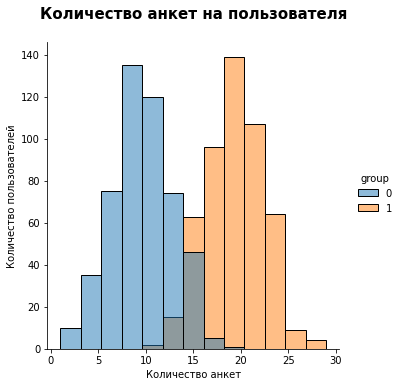

In [97]:
# Графическое отображения числа анкет на пользователя

sns.displot(quantity_per_user, hue='group', x = 'count_form')
plt.ylabel("Количество пользователей")
plt.xlabel("Количество анкет")
plt.title("Количество анкет на пользователя\n", fontsize=15, fontweight = 'bold')
plt.show()

In [98]:
# Проверка статистической значимости с помощью t-test

pg.ttest(x = quantity_per_user.query('group == 0')['count_form'], y = quantity_per_user.query('group == 1')['count_form'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-51.85607,997.694538,two-sided,2.005369e-285,"[-10.29, -9.54]",3.279531,9.827e+280,1.0


### 4. Подводим итоги
Для проверки статистической значимости эксперимента мы проверили влияние нового алгорима на количество мэтчей и анкет на пользователя.  Оба предположения продемонстрировали статистически значимый результат, полученное значение p-value < 0.05.

Это означает, что у нас есть достаточные доказательства того, что новый алгоритм улучшил качество сервиса, а значит стоит включить новую систему поиска анкет на всех пользователей.